In [1]:
from crocoddyl import *
import pinocchio as pin
import numpy as np

robot = loadBorinotArm()
robot.initViewer(loadModel=True)

q0 = [3.14, 0]
robot.q0.flat = q0
robot.framesForwardKinematics(robot.q0)
robot.display(robot.q0)

IDX_LINK1 = robot.model.getFrameId('link1', pin.FrameType.BODY)
IDX_LINK2 = robot.model.getFrameId('link2', pin.FrameType.BODY)
Mlink1 = robot.data.oMf[IDX_LINK1]
Mlink2 = robot.data.oMf[IDX_LINK2]

target_pos  = np.array([0,0,0.3])
target_quat = pin.Quaternion(1, 0, 0, 0)
target_quat.normalize()

Mref = pin.SE3()
Mref.translation = target_pos.reshape(3,1)
Mref.rotation = target_quat.matrix()

robot.viewer.gui.refresh()

In [14]:
state = StatePinocchio(robot.model)

xRegCost = CostModelState(robot.model, state, ref=state.zero(), nu=1)
xPendCost = CostModelDoublePendulum(robot.model, 
                                    frame=state, 
                                    ref=state.zero, 
                                    nu=1,
                                    activation=ActivationModelWeightedQuad(np.array([1,1,1,1]+[0.1]*2)))

uRegCost = CostModelControl(robot.model, nu = 1)
uLimCost = CostModelControl(robot.model, nu=1,
                            activation = ActivationModelInequality(np.array([-2]), np.array([2])))

runningCostModel = CostModelSum(robot.model, nu=1)
terminalCostModel = CostModelSum(robot.model, nu=1)

# runningCostModel.addCost(name="regx", weight=1e-6, cost=xRegCost)
runningCostModel.addCost(name="regu", weight=1e-3, cost=uRegCost)
runningCostModel.addCost(name="limu", weight=1e4, cost=uLimCost)
runningCostModel.addCost(name="pend", weight=1, cost=xPendCost)
terminalCostModel.addCost(name="ori2", weight=1e5, cost=xPendCost)

In [15]:
actModel = ActuationModelDoublePendulum(robot.model)
runningModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, runningCostModel))
terminalModel = IntegratedActionModelEuler(DifferentialActionModelUAM(robot.model, actModel, terminalCostModel))

In [16]:
# Defining the time duration for running action models and the terminal one
dt = 1e-2
runningModel.timeStep = dt

T = 100
x0 = np.array([3.14, 0, 0., 0. ])
problem = ShootingProblem(x0, [runningModel] * T, terminalModel)

In [25]:
# Creating the DDP solver for this OC problem, defining a logger
ddp = SolverFDDP(problem)
ddp.callback = [CallbackDDPVerbose()]
ddp.callback.append(CallbackDDPLogger())

#us0 = np.zeros([T,1])
us0 = ddp.us
xs0 = [problem.initialState+0.1]*len(ddp.models())

ddp.solve(init_xs=xs0,init_us=us0,maxiter=150)
#ddp.solve(maxiter=150)

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
   0  2.00201e+05  1.16096e+09  9.21968e+01  1.00000e+00  1.00000e+00   1.0000     1
   1  2.00200e+05  1.54461e+07  3.14734e+00  1.00000e+00  1.00000e+00   1.0000     1
   2  2.00199e+05  1.79399e+03  3.09626e-01  1.00000e+00  1.00000e+00   1.0000     1
   3  2.00199e+05  3.39328e+03  5.89887e-01  1.00000e+00  1.00000e+00   1.0000     1
   4  2.00197e+05  6.47120e+03  1.12549e+00  1.00000e+00  1.00000e+00   1.0000     1
   5  2.00195e+05  1.23441e+04  2.14841e+00  1.00000e+00  1.00000e+00   1.0000     1
   6  2.00190e+05  2.35492e+04  4.10323e+00  1.00000e+00  1.00000e+00   1.0000     1
   7  2.00180e+05  4.49270e+04  7.84407e+00  1.00000e+00  1.00000e+00   1.0000     1
   8  2.00162e+05  8.57134e+04  1.50217e+01  1.00000e+00  1.00000e+00   1.0000     1
   9  2.00128e+05  1.63545e+05  2.88639e+01  1.00000e+00  1.00000e+00   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  10  2.00061e

iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
  90  7.06504e+02  7.63770e-05  1.45883e-05  1.00000e-09  1.00000e-09   1.0000     1
  91  7.06504e+02  5.11423e-05  9.76851e-06  1.00000e-09  1.00000e-09   1.0000     1
  92  7.06504e+02  3.42431e-05  6.54071e-06  1.00000e-09  1.00000e-09   1.0000     1
  93  7.06504e+02  2.29268e-05  4.37925e-06  1.00000e-09  1.00000e-09   1.0000     1
  94  7.06504e+02  1.53496e-05  2.93195e-06  1.00000e-09  1.00000e-09   1.0000     1
  95  7.06504e+02  1.02763e-05  1.96290e-06  1.00000e-09  1.00000e-09   1.0000     1
  96  7.06504e+02  6.87959e-06  1.31409e-06  1.00000e-09  1.00000e-09   1.0000     1
  97  7.06504e+02  4.60553e-06  8.79723e-07  1.00000e-09  1.00000e-09   1.0000     1
  98  7.06504e+02  3.08311e-06  5.88921e-07  1.00000e-09  1.00000e-09   1.0000     1
  99  7.06504e+02  2.06392e-06  3.94241e-07  1.00000e-09  1.00000e-09   1.0000     1
iter 	 cost 	      stop 	    grad 	  xreg 	      ureg 	 step 	 feas
 100  7.06504e

([array([3.14, 0.  , 0.  , 0.  ]),
  array([ 3.18493483, -0.08713097,  4.49348266, -8.71309691]),
  array([ 3.22982922, -0.17422295,  4.48943897, -8.70919818]),
  array([ 3.27463368, -0.26123506,  4.48044665, -8.70121073]),
  array([ 3.31930116, -0.34813232,  4.46674731, -8.68972573]),
  array([ 3.3637864 , -0.43488528,  4.44852429, -8.67529596]),
  array([ 3.40804614, -0.52147104,  4.42597405, -8.65857693]),
  array([ 3.45203908, -0.60787411,  4.3992939 , -8.64030695]),
  array([ 3.49572575, -0.69408695,  4.36866709, -8.6212839 ]),
  array([ 3.5390682 , -0.78011034,  4.33424476, -8.60233823]),
  array([ 3.58202944, -0.86595335,  4.29612455, -8.58430185]),
  array([ 3.62457269, -0.95163308,  4.25432498, -8.56797262]),
  array([ 3.66666024, -1.03717382,  4.20875518, -8.5540736 ]),
  array([ 3.70825203, -1.12260589,  4.15917901, -8.54320694]),
  array([ 3.74930376, -1.2079639 ,  4.1051729 , -8.53580164]),
  array([ 3.78976453, -1.29328445,  4.04607641, -8.53205496]),
  array([ 3.82957387

In [39]:
displayTrajectory(robot, ddp.xs, runningModel.timeStep)

In [34]:
import time 
dt = 0.01
t = np.arange(0,1,dt)
q0 = np.array([[3.14,0]]).T

q = q0
q_d = np.zeros([2,1])
q_dd = np.zeros([2,1])

In [35]:
nle = np.zeros([2,1])
for i in range(len(t)):
    pin.computeAllTerms(robot.model, robot.data, q, q_d)
    M = robot.data.M
    Minv = np.linalg.inv(M)
    r = np.zeros([2,1])
    tau = np.zeros([2,1])
    tau[1,0] = ddp.us[i]
    nle[:,0] = m2a(robot.data.nle)    
    r[:] = tau - nle
    q_dd = np.dot(Minv, r)
    q = q + q_d*dt + q_dd*dt**2
    q_d = q_d + q_dd*dt
    #pin.forwardKinematics(robot.model, robot.data, q, q_d)
    robot.display(q)
    time.sleep(dt)

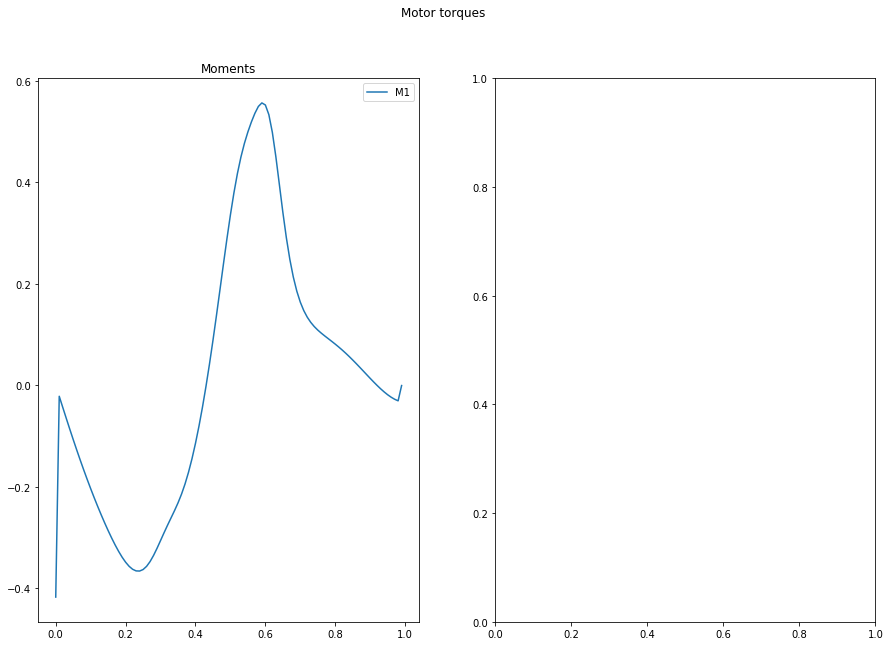

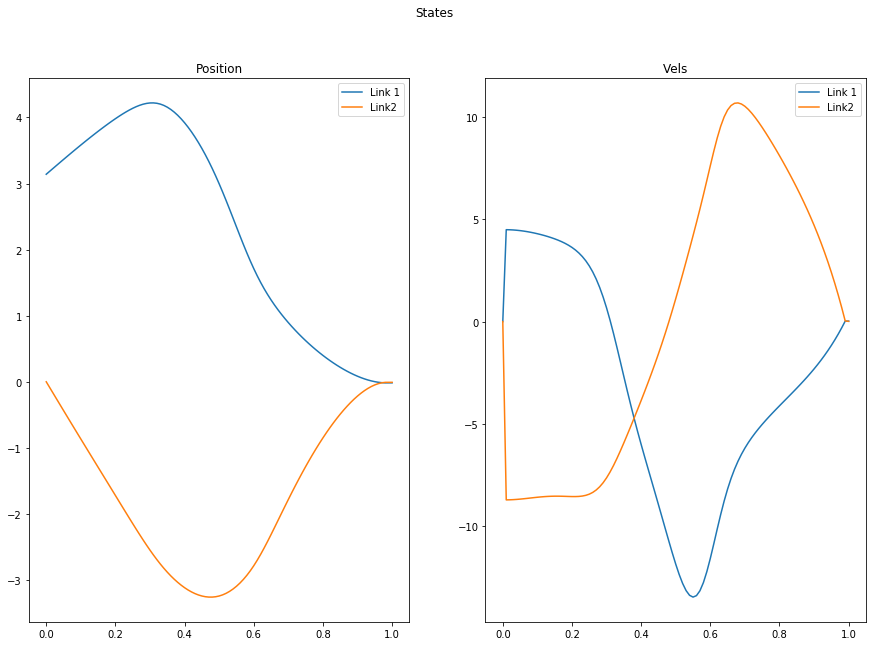

In [31]:
import numpy as np
import matplotlib.pyplot as plt

control = np.vstack(ddp.us)
t = np.arange(0,T*dt, dt)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('Motor torques')
# axs[0].plot(t,control[:,0], t,control[:,1])
axs[0].plot(t,control[:,0])
axs[0].set_title('Moments')
axs[0].legend(['M1','M2'])

t_state = np.append(t, t[-1]+dt)
state = np.vstack(ddp.xs)
fig, axs = plt.subplots(1,2, figsize=(15,10))
fig.suptitle('States')
axs[0].plot(t_state,state[:,0], t_state, state[:,1])
axs[0].set_title('Position')
axs[0].legend(['Link 1','Link2'])
axs[1].plot(t_state,state[:,2], t_state, state[:,3])
axs[1].set_title('Vels')
axs[1].legend(['Link 1','Link2'])